# 10. Linear Regression

This chapter will introduce you to linear regression analysis in R. We will cover how to fit linear regression models, checking model assumptions using diagnostic plots, adding transformations and interactions, performance metrics, and variable selection using stepwise selection. 

For this chapter, we will use the a samples from the National Health and Nutrition Examination Survey ([NHANES](https://www.cdc.gov/nchs/nhanes/index.htm)). The sample contains lead, blood pressure, BMI, smoking status, alcohol use, and demographic variables from NHANES 1999-2018. Variable selection and feature engineering were conducted in an effort to replicate the regression analyses conducted by [Huang, Z. (2022). Association Between Blood Lead Level With High Blood Pressure in US (NHANES 1999-2018). Frontiers in Public Health, 892](frontiersin.org/articles/10.3389/fpubh.2022.836357/full). Use the help operator `?NHANESsample` to read the variable descriptions. Note that we ignore survey weights for this analysis. 

We will use the `broom` package to present the estimated coefficients for our regression models and the `car` package to compute variance-inflation factors.

In [1]:
library(RforHDSdata)
library(tidyverse)
library(patchwork)
library(broom)
library(car)
data(NHANESsample)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




## Linear Regression Model Form and Assumptions

Recall, that linear regression models an outcome variable $y$ as a linear combination of independent variables. Suppose we have $p$ dependent variables, then the model takes the form $$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_p x_p + \epsilon,$$ where $\epsilon$ is an error or noise term. In standard linear regression, we assume that $\epsilon$ is independent and follows a normal distribution $N(0, \sigma^2)$. From this model form we can extract the key assumptions of linear regression. It's important to remember these assumptions when checking the model fit and interpreting the model results. 

- **Linearity**: The relationship between the independent variables and the dependent variables is linear. This means that the change in the dependent variable is proportional to the change in the independent variable(s). We can check for linearity by examining scatter plots or performing diagnostic tests.

- **Independence**: The observations in the dataset are assumed to be independent of each other. There should be no systematic relationship or correlation between the residuals (the differences between the predicted and observed values). Independence can be violated when there is autocorrelation or when observations are clustered or dependent on each other.

- **Homoscedasticity**: The variance of the residuals is constant across all levels of the independent variables. In other words, the spread or dispersion of the residuals should remain consistent throughout the range of the independent variable(s). Violations of homoscedasticity, called heteroscedasticity, can lead to biased standard errors and incorrect hypothesis tests.

- **Normality**: The residuals follow a normal distribution. This assumption allows for valid hypothesis testing, confidence interval estimation, and prediction intervals. Departures from normality can affect the accuracy of statistical inferences, especially when dealing with small sample sizes. However, the central limit theorem helps to mitigate minor departures from normality in large samples.

- **No multicollinearity**: The independent variables should not be highly correlated with each other. High multicollinearity can lead to unstable and unreliable estimates of the coefficients. It becomes challenging to distinguish the individual effects of the independent variables, and the interpretation of the model becomes problematic. Detecting multicollinearity can be done using correlation matrices or variance inflation factor (VIF) calculations. While this is not a direct assumption of the model, it's an important part of model fitting. 


In Chapter 4, we presented some initial exploratory analysis fo this data. In this chapter, we will use linear regression to understand the assocaition between blood lead levels and systolic blood pressure adjusting for possible confounders. To start, we create columns for systolic and diastolic blood pressure. If an observation has one blood pressure reading, then we use that value. If there is more than one blood pressure reading, then we drop the first observation and average the rest. We do a complete case analysis by dropping any observation with NA values. This leaves us with 30,405 observations. 

In [2]:
NHANESsample$SBP <- apply(NHANESsample[,c("SBP1", "SBP2", "SBP3", "SBP4")], 1, 
                       function(x) case_when(sum(!is.na(x)) == 0 ~ NA, 
                                             sum(!is.na(x)) == 1 ~ mean(x, na.rm=TRUE),
                                             sum(!is.na(x)) > 1 ~ mean(x[-1], na.rm=TRUE))) 
NHANESsample$DBP <- apply(NHANESsample[,c("DBP1", "DBP2", "DBP3", "DBP4")], 1, 
                       function(x) case_when(sum(!is.na(x)) == 0 ~ NA, 
                                             sum(!is.na(x)) == 1 ~ mean(x, na.rm=TRUE),
                                             sum(!is.na(x)) > 1 ~ mean(x[-1], na.rm=TRUE)))                       
nhanes_df <- na.omit(subset(NHANESsample, select= -c(SBP1, SBP2, SBP3, SBP4, DBP1, DBP2, DBP3, DBP4)))
dim(nhanes_df)

[1] 30405    15

Next, we make sure any categorical variables are coded as factors.

In [3]:
nhanes_df$SEX <- as.factor(nhanes_df$SEX)
nhanes_df$RACE <- as.factor(nhanes_df$RACE)
nhanes_df$EDUCATION <- as.factor(nhanes_df$EDUCATION)
nhanes_df$BMI_CAT <- as.factor(nhanes_df$BMI_CAT)
nhanes_df$LEAD_QUANTILE <- as.factor(nhanes_df$LEAD_QUANTILE)

## Simple Linear Regression

We will start with simple linear regression. Below we plot the relationship between blood lead level and our outcome systolic blood pressure using the cateogrical variable `LEAD_QUANTILE` and the continuous variable `LEAD`. It easy to visualize the assumptions of simple linear regression. First, the survey sampling for the NHANES survey allows us to assume that each observation is independent. Now, let's look at the plots below. We expect to see that the average systolic blood pressure increases linearly with blood lead level and that the observations look normally distributed with equal variance along that line. Below, we do not observe that to be the case. We will come back to this in the section on transformations and interactions. 

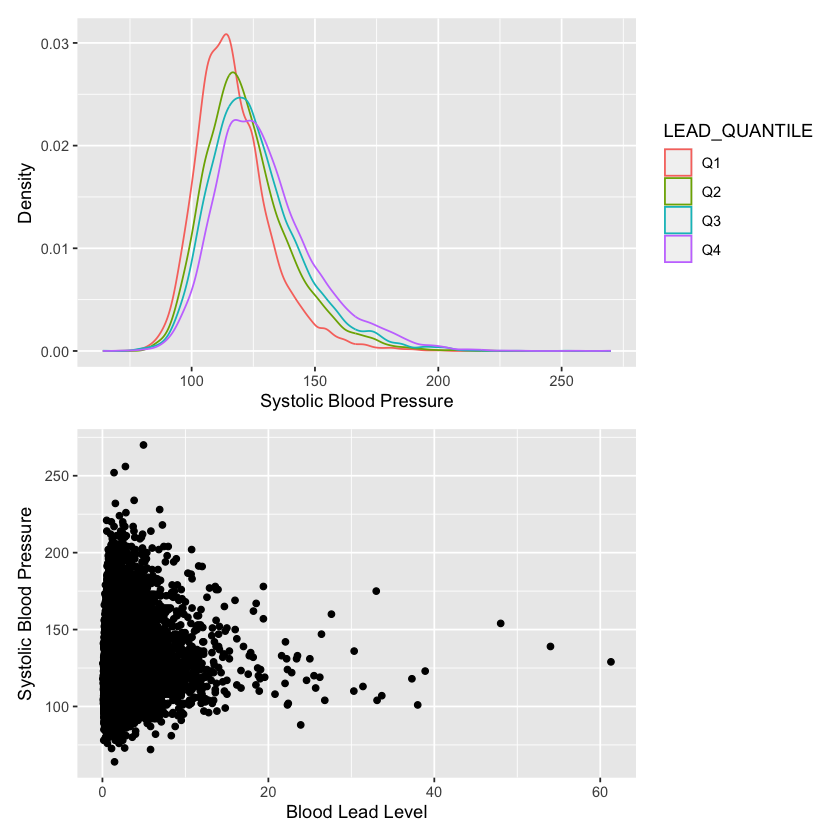

In [31]:
p1 <- ggplot(nhanes_df)+
  geom_density(aes(x=SBP, color=LEAD_QUANTILE)) + 
  labs(x="Systolic Blood Pressure", y="Density")
p2 <- ggplot(nhanes_df)+
  geom_point(aes(x=LEAD, y=SBP)) + 
  labs(x="Blood Lead Level", y="Systolic Blood Pressure")
p1/p2

Despite our observations, we will fit a simple linear regression model to explain the association between `SBP` and `LEAD`. The function `lm(formula = y ~ x, data)` fits a linear model in R. The first argument is formula of the linear model. On the left hand side of the `~` we put the outcome variable and on the right hand side we put the dependent variable. When we have multiple depedent variables we separate them with a `+` (e.g. `y~x1+x2`). The output of this function is an `lm` object. The `summary()` function will print a summary of the model including the estimated coefficients, information about the residuals, the R-squared and adjusted R-squared values, and the F-statistic. 

In [5]:
simp_model <- lm(formula = SBP~LEAD, data = nhanes_df)
summary(simp_model)


Call:
lm(formula = SBP ~ LEAD, data = nhanes_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-96.360 -12.519  -2.791   9.363 140.880 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 120.66481    0.14950  807.11   <2e-16 ***
LEAD          1.70820    0.05802   29.44   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 18.47 on 30403 degrees of freedom
Multiple R-squared:  0.02772,	Adjusted R-squared:  0.02769 
F-statistic: 866.8 on 1 and 30403 DF,  p-value: < 2.2e-16


To visualize this model, we can add the estimated regression line to our scatter plot. In `ggplot`, this can be done with the `geom_smooth()` function. In base R, we use the `abline()` function. 

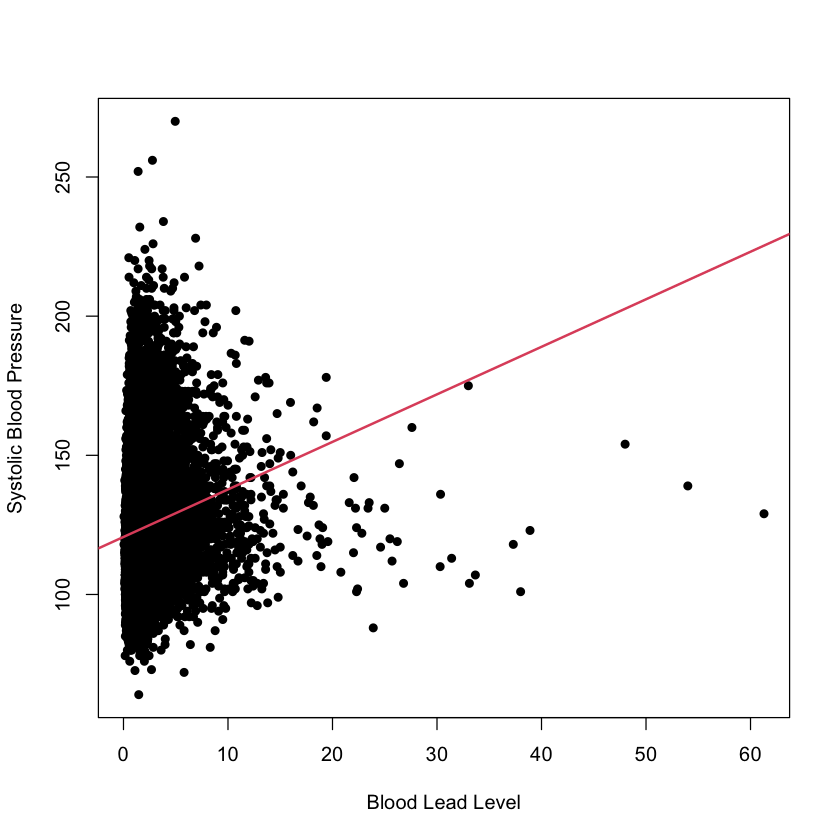

In [6]:
plot(nhanes_df$LEAD, nhanes_df$SBP, ylab=c("Systolic Blood Pressure"),xlab=c("Blood Lead Level"),pch=16)
abline(simp_model,col=2,lwd=2)

## Multiple Linear Regression

We now create a model adjusting age and sex. We add these into the model by specifying a new formula. 

In [7]:
adj_model <- lm(SBP ~ LEAD + AGE + SEX, data = nhanes_df)
summary(adj_model)


Call:
lm(formula = SBP ~ LEAD + AGE + SEX, data = nhanes_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-65.623 -10.592  -1.551   8.547 131.595 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 101.785406   0.303532 335.337  < 2e-16 ***
LEAD          0.400071   0.055246   7.242 4.54e-13 ***
AGE           0.461932   0.005567  82.971  < 2e-16 ***
SEXFemale    -2.777737   0.195674 -14.196  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.64 on 30401 degrees of freedom
Multiple R-squared:  0.2116,	Adjusted R-squared:  0.2115 
F-statistic:  2720 on 3 and 30401 DF,  p-value: < 2.2e-16


We can also extract the regression coefficients from the model using the `coef()` function or by using the `tidy` function from the `broom` package. This function puts the coefficient estimates, standard errors, statistics, and p-values in a data frame. We can also add a confidence interval. Below, we add a 95% confidence interval (which is the default value for `conf.level`). 

In [8]:
tidy(adj_model, conf.int=TRUE, conf.level=0.95)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),101.7854062,0.303531788,335.33689,0.000000e+00,101.1904712,102.3803413
LEAD,0.4000715,0.055246352,7.24159,4.539720e-13,0.2917863,0.5083566
AGE,0.4619320,0.005567391,82.97099,0.000000e+00,0.4510196,0.4728443
SEXFemale,-2.7777367,0.195674149,-14.19573,1.362265e-45,-3.1612662,-2.3942071


Some other useful summary functions are `resid()`, which returns the residual values for the model, and `fitted()`, which returns the fitted values. We can also predict on new data using the `predict()` function. Below we find the summary of the residual values and then plot the fitted vs true values.

In [9]:
summary(resid(adj_model))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-65.624 -10.592  -1.551   0.000   8.547 131.595 

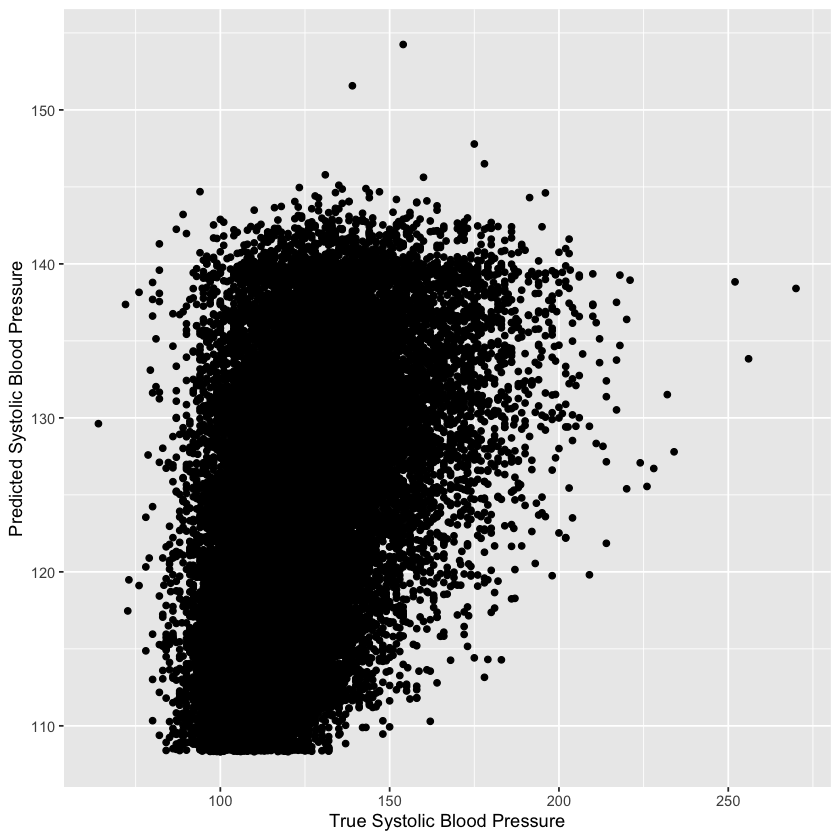

In [10]:
ggplot()+geom_point(aes(x=nhanes_df$SBP, y=fitted(adj_model)))+
  labs(x="True Systolic Blood Pressure", y="Predicted Systolic Blood Pressure")

The model summary above shows that the reference level for sex is male. If we want to change our reference level, we can reorder the factor variable by either using the `factor()` function and specifying `Female` as the first level or by using the `relevel()` function. The `ref` argument specifies the new reference level.  

In [11]:
nhanes_df$SEX <- relevel(nhanes_df$SEX, ref="Female")
adj_model2 <- lm(SBP ~ LEAD + AGE + SEX, data = nhanes_df)
tidy(adj_model2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),99.0076695,0.292867408,338.06312,0.000000e+00
LEAD,0.4000715,0.055246352,7.24159,4.539720e-13
AGE,0.4619320,0.005567391,82.97099,0.000000e+00
SEXMale,2.7777367,0.195674149,14.19573,1.362265e-45


## Diagnostic Plots and Measures

We can tell from the above plot that our model doesn't have a great fit. We will use some diagnostic measures to learn more. R has some built-in plots available for a linear regression model. We plot these below using the `plot()` function. The four plots include (a) Residuals vs Fitted, (b) a QQ-plot for the residuals, (c) Standardized residuals (sqrt) vs Fitted, and (d) Standardized Residuals vs Leverage. In the last plot, you may observe that there is a dashed line. Any points outside of these lines have a Cook’s distance of greater than 0.5. Additionally, points with labels correspond to the points with the largest residuals. So this last plot tries to summarize the outliers, leverage, and influential points. The plots below show that our residuals do not look normally distributed and that we have may have some high leverage points.

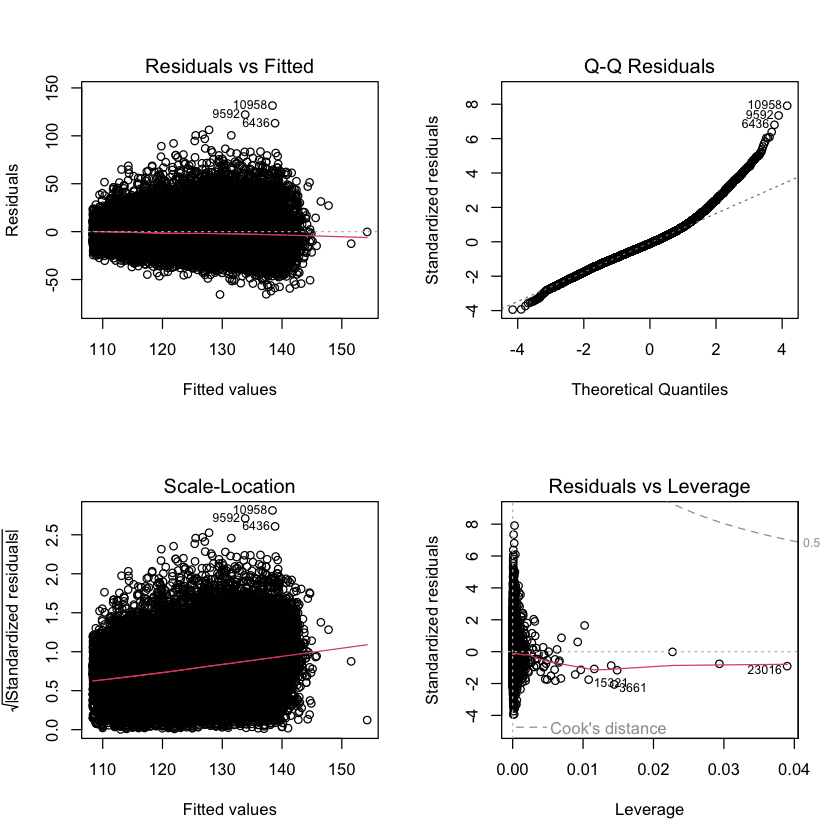

In [12]:
par(mfrow=c(2,2)) # plots all four plots together
plot(adj_model)

### Normality

Beyond the default plots, we can also plot the histogram of the residuals and a qq-plot. The `qqnorm()` and `qqline()` functions can take in the residuals from our model as an argument. The latter adds the theoretical red line for reference. As both the histogram and qq-plot shown, the residuals are positive-skewed, and thus normality of our residuals is not satisfied, we will introduce how we might transform this dataset to satisfy this assumption later in this chapter.

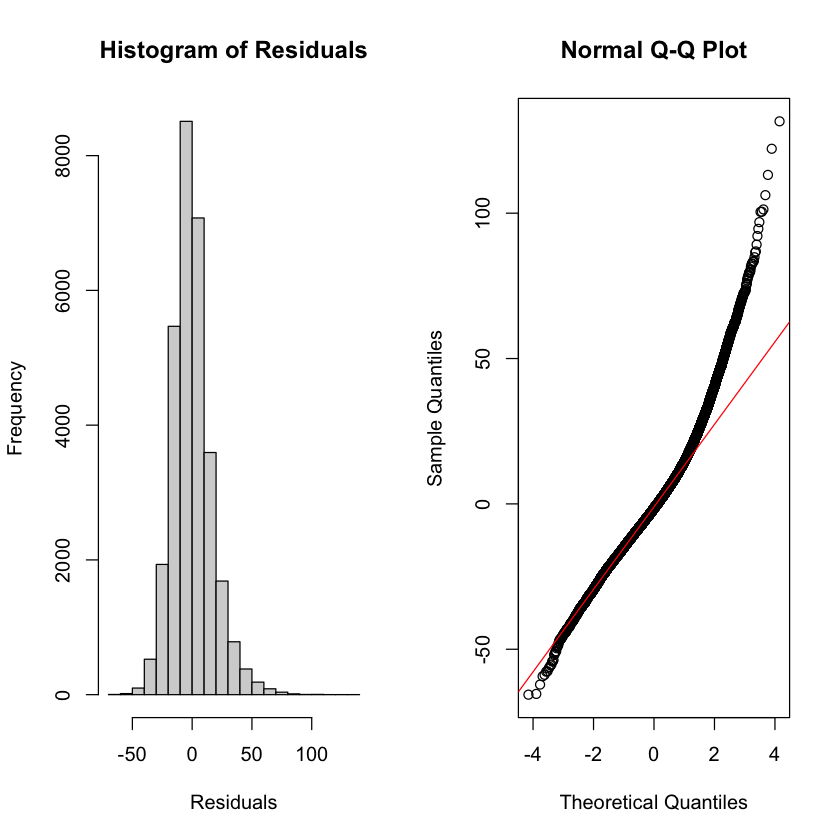

In [13]:
par(mfrow=c(1,2)) # plot next to each other
hist(resid(adj_model), xlab="Residuals", main="Histogram of Residuals") 
qqnorm(resid(adj_model))
qqline(resid(adj_model),col="red") 

Instead of using the direct residuals, we could also use the standardized residuals using the function `rstandard()`. The standardized residuals are the raw residuals divided by an estimate of the standard deviation for the residual, which will be different for each observation.

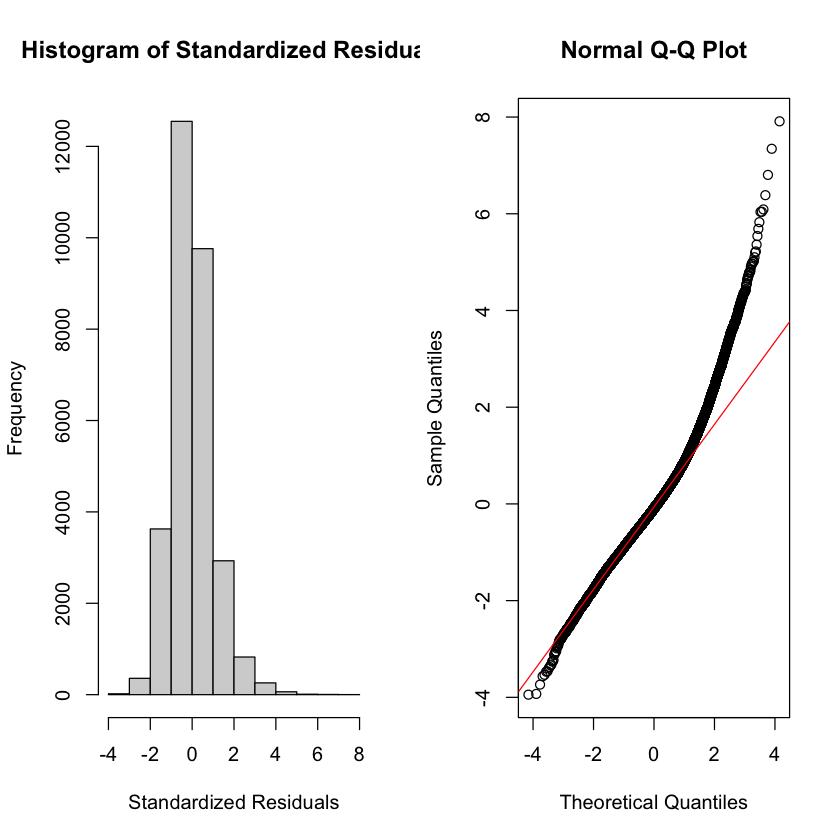

In [14]:
par(mfrow=c(1,2)) 
hist(rstandard(adj_model), xlab="Standardized Residuals", main="Histogram of Standardized Residuals") 
qqnorm(rstandard(adj_model)) 
qqline(rstandard(adj_model),col="red")

### Homoscedasticity, Linearity, and Collinearity

We can also create a residual vs fitted plot and plot covariates against the residuals. Below, we plot the blood lead level agains the residuals. In both plots, we are looking for the points to be spread roughly evenly around 0 and has no discerning pattern. However, both plots shows a tunnel shape, indicating a growing and shrinking variance of residuals. This indicates that we are violating the homoscedasticity assumption.

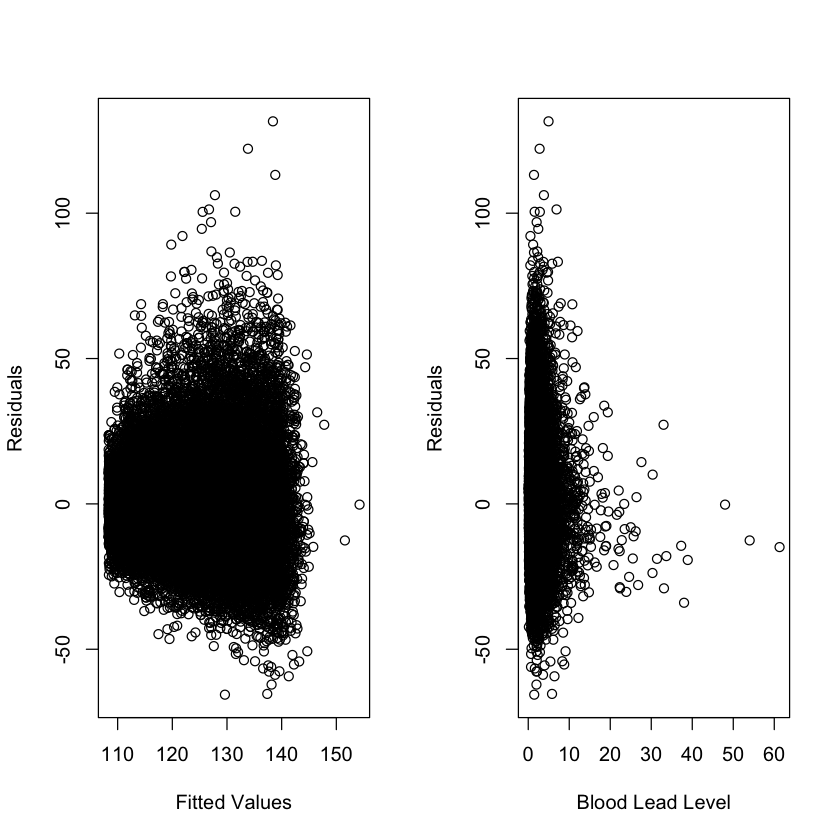

In [15]:
par(mfrow=c(1,2))
plot(fitted(adj_model), resid(adj_model), xlab="Fitted Values", ylab="Residuals")
plot(nhanes_df$LEAD, resid(adj_model), xlab="Blood Lead Level", ylab="Residuals")

To quantify any collinearity between the included covariates we can use the variance inflation factors. The `vif()` function in the `car` package allows us to calculate the variance inflation factors or generalized variance inflation factors for all covariates. In our case, all the VIF values are around 1, indicating low levels of collinearity. 

In [16]:
vif(adj_model)

LEAD      AGE      SEX 
1.118042 1.069719 1.048606

### Leverage and Influence

We may also be interested in how each observation is influencing the model. Leverage values measure how much an individual observation's $y$ value influenes its own predicted value and indicate that an observation has extreme predictor values compared to the rest of the data. Leverage values range from 0 to 1 and sum to $p+1$, the number of estimated coefficients. Observations with high leverage have the potential to significantly impact the estimated regression coefficients and the overall fit of the model. Therefore, examining leverage values helps identify observations that may be influential or outliers. Below we find the ten highest leverage values and then find those observations in the data. 

In [17]:
sort(hatvalues(adj_model), decreasing=TRUE)[1:10]
nhanes_df[order(hatvalues(adj_model), decreasing=TRUE),] %>% head()

23016        2511        3091       21891        3661         511 
0.038986057 0.029359436 0.022698800 0.014841727 0.014432719 0.013993186 
      21892       15321        6511        3452 
0.011587215 0.010797767 0.010220042 0.009679122

,ID,AGE,SEX,RACE,EDUCATION,INCOME,SMOKE,YEAR,LEAD,BMI_CAT,LEAD_QUANTILE,HYP,ALC,SBP,DBP
,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>
23016,69212,38,Male,Mexican American,LessThanHS,1.03,NeverSmoke,2011,61.29,BMI>=30,Q4,0,Yes,129,59
2511,8942,61,Male,Other Hispanic,MoreThanHS,2.25,NeverSmoke,1999,54.00,25<BMI<30,Q4,1,Yes,139,74
3091,10802,72,Male,Non-Hispanic White,MoreThanHS,5.00,QuitSmoke,2001,48.00,BMI<=25,Q4,1,Yes,154,82
21891,66079,54,Male,Non-Hispanic Black,HS,1.65,StillSmoke,2011,38.90,BMI>=30,Q4,1,No,123,74
3661,12848,39,Male,Mexican American,MoreThanHS,4.14,NeverSmoke,2001,38.00,BMI<=25,Q4,0,Yes,101,54
511,1882,34,Male,Non-Hispanic White,HS,1.36,StillSmoke,1999,37.30,BMI<=25,Q4,1,Yes,118,80


Some other measures of influence are the DFBETAs and the Cook's distance. These measure how much each observation influences the estimated coefficients and the estimated `y` values, respectively. The `influence.measures()` function provides a set of measures, including the DFBETAS for each model variable, DFFITS, covariance ratios, Cook's distances and the leverage values, that quantify the influence of each observation on a linear regression model. The output returns the values in a matrix called `infmat`, which we convert to a data frame below.

In [18]:
inf_mat <- influence.measures(adj_model)[['infmat']]
as.data.frame(inf_mat) %>% head()

,dfb.1_,dfb.LEAD,dfb.AGE,dfb.SEXF,dffit,cov.r,cook.d,hat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0138799518,-0.0175643062,-1.683345e-02,0.0083187286,-0.034265619,0.9995083,2.934831e-04,1.898938e-04
2,-0.0007323058,0.0003481166,-3.918891e-05,0.0010513411,-0.001495317,1.0001932,5.590112e-07,6.607023e-05
3,0.0221373044,0.0057489501,-1.454111e-02,-0.0168432662,0.029635103,0.9988200,2.194905e-04,8.280908e-05
4,0.0004990424,0.0010428901,-2.072439e-03,0.0016309535,-0.003115033,1.0002393,2.425931e-06,1.184573e-04
5,0.0022594480,-0.0027253450,-2.499295e-03,0.0009734915,-0.004978427,1.0003527,6.196367e-06,2.349179e-04
6,-0.0012828825,-0.0005585861,1.647487e-03,-0.0029288547,-0.004412697,1.0001808,4.868096e-06,8.089475e-05


## Interactions and Transformations

We now try to update our model. To start, we look at potential transformations for our outcome variable. We will consider a log transformation for our outcome systolic blood pressure and blood lead level. Both of these variables have a fairly skewed distribution and may benefit from a transformation.

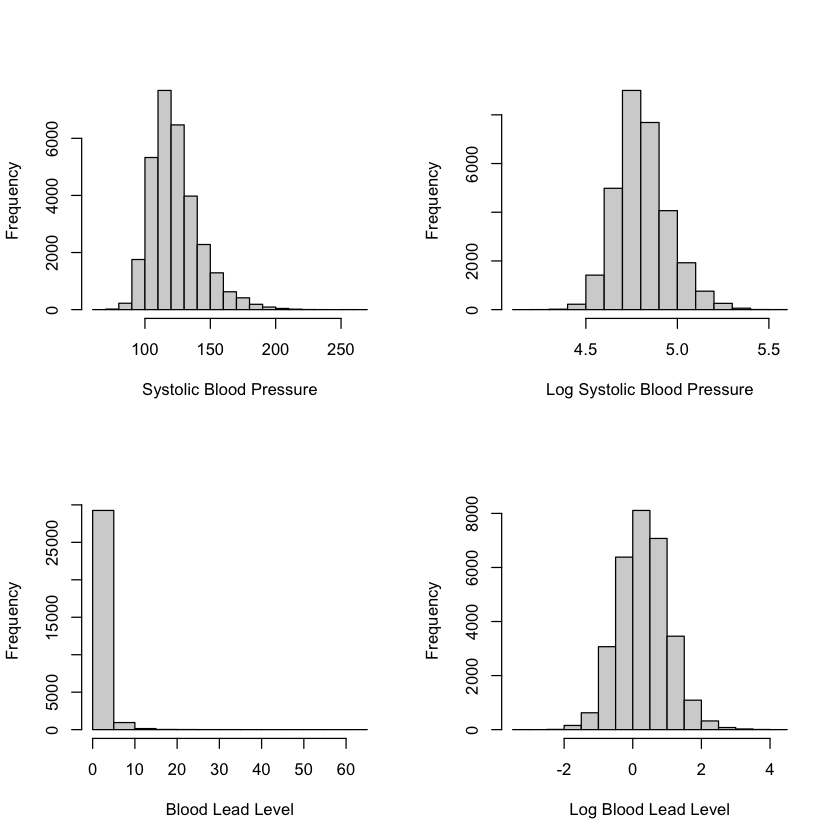

In [19]:
par(mfrow=c(2,2))
hist(nhanes_df$SBP, xlab="Systolic Blood Pressure", main="")
hist(log(nhanes_df$SBP), xlab="Log Systolic Blood Pressure", main="")
hist(nhanes_df$LEAD, xlab="Blood Lead Level", main="")
hist(log(nhanes_df$LEAD), xlab="Log Blood Lead Level", main="")

To add a transformation to a model we can apply the transformation in the formula. We will calculate the adjusted R-squared for each potential model to compare the fit and plot the four qq-plots. Both indicate that the log-log transformation is the best fit. 

In [20]:
model_nlog_nlog <- lm(SBP ~ LEAD + AGE + SEX, data = nhanes_df)
model_log_nlog <- lm(log(SBP) ~ LEAD + AGE + SEX, data = nhanes_df)
model_nlog_log <- lm(SBP ~ log(LEAD) + AGE + SEX, data = nhanes_df)
model_log_log <- lm(log(SBP) ~ log(LEAD) + AGE + SEX, data = nhanes_df)

In [21]:
summary(model_nlog_nlog)$adj.r.squared
summary(model_log_nlog)$adj.r.squared
summary(model_nlog_log)$adj.r.squared
summary(model_log_log)$adj.r.squared

[1] 0.2115378

[1] 0.2146037

[1] 0.211921

[1] 0.2150189

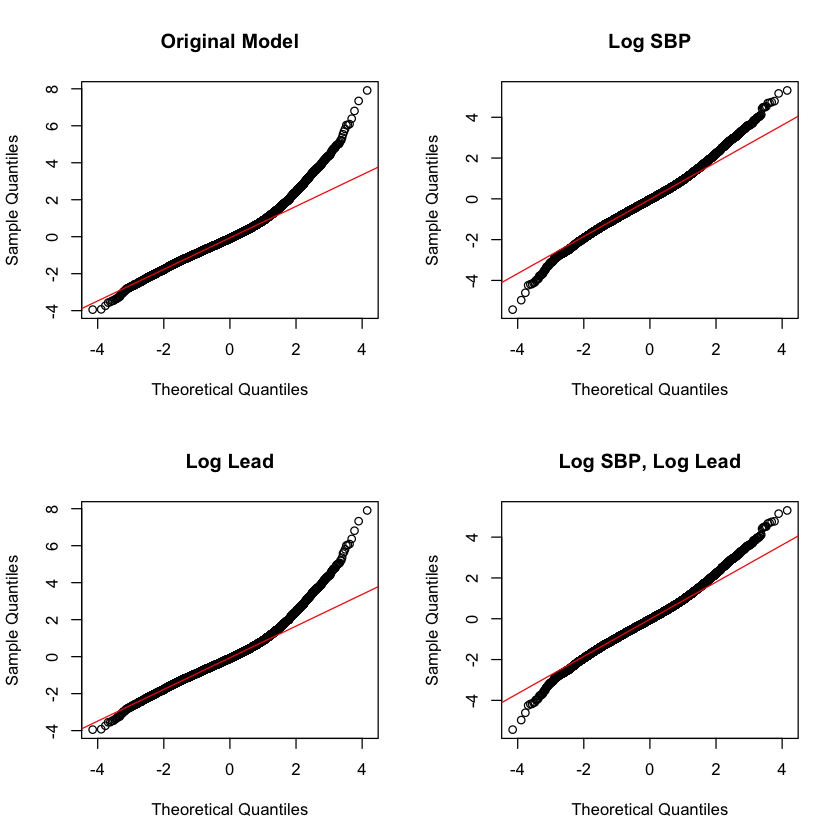

In [22]:
par(mfrow=c(2,2))
qqnorm(rstandard(model_nlog_nlog), main="Original Model") 
qqline(rstandard(model_nlog_nlog),col="red")
qqnorm(rstandard(model_log_nlog), main="Log SBP") 
qqline(rstandard(model_log_nlog),col="red")
qqnorm(rstandard(model_nlog_log), main="Log Lead") 
qqline(rstandard(model_nlog_log),col="red")
qqnorm(rstandard(model_log_log), main="Log SBP, Log Lead") 
qqline(rstandard(model_log_log),col="red")

We can modify the above code to add square root transformations or inverse transformations. Additionally, we might consider polynomial transformations. The `poly(x, degree=1)` function allows us to specify a polynomial transformation where we might have higher degree terms. We do not pursue this for this example but show some example code below to create a cubic transformation for blood lead level.

In [23]:
model_poly <- lm(SBP ~ poly(LEAD, 3) + AGE + SEX, data = nhanes_df)

We can summarize the outcome for our log-log model using the `tidy()` function again. We observe small p-values for each estimated coefficient.

In [24]:
tidy(model_log_log)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.620621472,2.391943e-03,1931.743667,0.000000e+00
log(LEAD),0.008909484,1.183673e-03,7.526978,5.336443e-14
AGE,0.003494946,4.573668e-05,76.414522,0.000000e+00
SEXMale,0.025427995,1.547464e-03,16.432047,2.055983e-60


Another type of transformation is an interaction term. For example, we may consider an interaction between sex and blood lead level. We add an interaction to the formula using a `:` between the two variables. 

In [25]:
model_interaction <- lm(log(SBP) ~ log(LEAD) + AGE + SEX + SEX:log(LEAD), data=nhanes_df) 
summary(model_interaction)


Call:
lm(formula = log(SBP) ~ log(LEAD) + AGE + SEX + SEX:log(LEAD), 
    data = nhanes_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.69806 -0.08161 -0.00491  0.07524  0.65992 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        4.621e+00  2.387e-03 1936.15   <2e-16 ***
log(LEAD)          2.364e-02  1.681e-03   14.07   <2e-16 ***
AGE                3.448e-03  4.578e-05   75.30   <2e-16 ***
SEXMale            3.323e-02  1.668e-03   19.92   <2e-16 ***
log(LEAD):SEXMale -2.660e-02  2.159e-03  -12.32   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1279 on 30400 degrees of freedom
Multiple R-squared:  0.219,	Adjusted R-squared:  0.2189 
F-statistic:  2131 on 4 and 30400 DF,  p-value: < 2.2e-16


## Evaluation Metrics

Besides the adjusted R-squared, there are other metrics that help us to understand how well our model fits the data and to help with model selection. The `AIC()` and `BIC()` functions find the Akaike information criterion (AIC) and Bayesian information criterion (BIC) values, respectively. Both AIC and BIC balance the trade-off between model complexity and goodness of fit. AIC takes into account both the goodness of fit (captured by the likelihood of the model) and the complexity of the model (captured by the number of parameters used). Lower AIC values are preferable. BIC is similar to AIC but has a stronger penalty for model complexity compared to AIC. Both measures indicate a preference for keeping the interaction term.

In [26]:
AIC(model_log_log)
AIC(model_interaction)

[1] -38610.47

[1] -38759.96

In [27]:
BIC(model_log_log)
BIC(model_interaction)

[1] -38568.86

[1] -38710.02

The `predict()` function allows us to calculate the predicted `y` values. When called on a model with no data specified, it returns the predicted values for the training data. We could also specify new data using the `newdata` argument. The new data provided must contain the columns given in the model formula. We use the `predict()` function to find the predicted values and then calculate the mean absolute error (MAE) and mean squared error (MSE) for our model. MAE is less sensitive to outliers compared to MSE. 

In [28]:
pred_y <- predict(model_interaction)

In [29]:
mae <- mean(abs(nhanes_df$SBP - pred_y))
mae

ERROR: Error in eval(expr, envir, enclos): object 'SBP' not found


In [ ]:
mse <- mean((nhanes_df$SBP- pred_y)^2)
mse

## Stepwise Selection

So far we have ignored the other variables in the data frame. When performing variable selection, there are multiple methods to use. We will end this chapter by demonstrating how to implement stepwise selection in R. The `step()` function takes in an initial model to perform stepwise selection on along with a direction `direction` ("forward", "backward", or "both"), and a scope `scope`. The scope specifies the lower and upper formula to consider. Below we use forward selection so the lower formula is the formula for our current model and the upper formula contains the other covariates we are considering adding in. These two formulas must be nested - that is all terms in the lower formula must be contained in the upper formula. 

By default, the `step()` function prints each step in the process and uses AIC to . We can set `trace=0` to avoid the print behavior and update the argument `k` to `log(n)` to use BIC, where `n` is the number of observations. Below we see that the algorithm first adds in race, then BMI, then income, then education, then smoking status. In fact, all variables were added to the model! The final output is an lm object that we can use. We get the summary of the final model and see that the adjusted R-squared has improved to 0.2479.

In [ ]:
mod_step <- step(model_interaction, direction = 'forward', 
                 scope = list(lower = "log(SBP) ~ log(LEAD) + AGE + SEX:log(LEAD)", 
                              upper = "log(SBP) ~ log(LEAD) + AGE + SEX:log(LEAD) + SEX + RACE + EDUCATION + SMOKE +
              INCOME + BMI_CAT"))

In [ ]:
summary(mod_step)

## Recap Video

## Exercises

For these exercises, we will be using the NHANES data.

1. Construct a linear model using `DBP1` as output and `LEAD`, `AGE`, `EVER_SMOKE` as features, and interpretate each estimate in the output.

In [ ]:
#solution:
model_exercise1 <- lm(DBP~LEAD + AGE + SMOKE, data = nhanes_df)
summary(model_exercise1)

2. Catch the interaction between `AGE` and `EVER_SMOKE` in the linear model.

In [ ]:
#solution:
model_exercise2 <- lm(DBP ~ LEAD + AGE + SMOKE + SMOKE:AGE, data = nhanes_df)
summary(model_exercise2)

3. Draw a qq plot for the model in exercise 2, and describe the distribution.

In [ ]:
#solutions:
qqnorm(rstandard(model_exercise2)) 
qqline(rstandard(model_exercise2),col="red") 
#qq plot shows a fat-tail trend


4. Try some diagnostic plots such as Residual vs. fitted value to see which transformation is fitted for this model.

In [ ]:
#solution:

#use log(DBP1 + 1) beacuase DBP1 has 0, and r can't deal with log transformation with 0
#this transformation creates the most outliers, but it also makes the model more normally
#distributed and Homoscedasticity
model_exercise4 <- lm(log(DBP+1) ~ LEAD + AGE + SMOKE + SMOKE:AGE, data=nhanes_df) 
summary(model_exercise4)

par(mfrow=c(2,2))
plot(model_exercise4)

5. Check MAE, MSE, and AIC of the model developed in question 2.

In [ ]:
#solutions:

#first find the prediction by this model
predicted <- predict(model_exercise2)

#mae
mae <- mean(abs(nhanes_df$DBP - predicted))
cat('MAE: ', mae, '\n')

#mse
mse <- mean((nhanes_df$DBP- predicted)^2)
cat('MSE: ', mse, '\n')

#aic
aic <- AIC(model_exercise2)
cat('AIC: ', aic)

7. Use `DBP1` as outcome, use forward selection method to choose the best model.

TODO: suppress messages and warnings

TODO: formula . and -